<a href="https://colab.research.google.com/github/jaazinneyoow/PAS_MP1/blob/main/jazin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mengimpor library yang diperlukan untuk pemrosesan data, visualisasi, dan pelatihan model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os
import keras
import random
import shutil
from matplotlib.image import imread
from pathlib import Path
import shutil
import random
from PIL import Image
import warnings
# Menonaktifkan peringatan untuk menjaga kebersihan output
warnings.filterwarnings('ignore')
from pathlib import Path

import tensorflow as tf

from tensorflow import keras
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout,BatchNormalization,Dropout
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import class_weight
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
from google.colab import files
# Mengunggah file dari komputer ke Google Colab
# file yang di upload adalah kaggle.json ( key api kaggle kita )
# agar bisa langsung download kaggle langsung di collab
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jazinvolney","key":"34dff0fe24a22d16184f881e1834bdf0"}'}

In [ ]:
# Membuat folder untuk menyimpan file kaggle.json tadi
!mkdir ~/.kaggle
# Memasukkan file kaggle.json ke direktori yang baru dibuat
!cp kaggle.json ~/.kaggle/
# Mengatur izin file ( tidak bisa di read selain kita ) agar kredensial tetap aman
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
#mendownload dataset kedua
!kaggle datasets download -d puneet6060/intel-image-classification

Dataset URL: https://www.kaggle.com/datasets/puneet6060/intel-image-classification
License(s): copyright-authors
 92% 320M/346M [00:00<00:00, 755MB/s]
100% 346M/346M [00:00<00:00, 703MB/s]


In [ ]:
data = "/content/intel-image-classification.zip"
zip_ref = zipfile.ZipFile(data, 'r')
# Extract semua konten ( image ) dalam zip
zip_ref.extractall('/content/data')
zip_ref.close()

In [ ]:
# Fungsi untuk menghitung file di setiap subdirektori dari direktori yang diberikan
def count_files_in_subdirectories(directory):
    for subdir, _, files in os.walk(directory):
        if subdir != directory: # Kecualikan direktori dasar itu sendiri
            print(f"Jumlah file di {os.path.basename(subdir)}: {len(files)}")

# Hitung file di direktori kereta
print("Jumlah foto di direktori train:")
count_files_in_subdirectories("/content/data/seg_train")

# Hitung file di direktori pengujian
print("\nJumlah foto di direktori test:")
count_files_in_subdirectories("/content/data/seg_test")

Jumlah foto di direktori train:
Jumlah file di seg_train: 0
Jumlah file di mountain: 2512
Jumlah file di forest: 2271
Jumlah file di sea: 2274
Jumlah file di street: 2382
Jumlah file di glacier: 2404
Jumlah file di buildings: 2191

Jumlah foto di direktori test:
Jumlah file di seg_test: 0
Jumlah file di mountain: 525
Jumlah file di forest: 474
Jumlah file di sea: 510
Jumlah file di street: 501
Jumlah file di glacier: 553
Jumlah file di buildings: 437


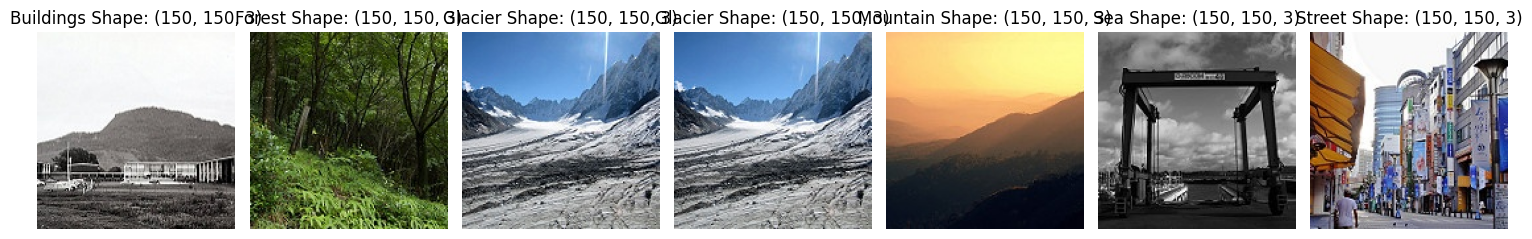

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.image import imread

# Data gambar dan label (judul)
images = [
    ('/content/data/seg_train/seg_train/buildings/0.jpg', 'Buildings'),
    ('/content/data/seg_train/seg_train/forest/10007.jpg', 'Forest'),
    ('/content/data/seg_train/seg_train/glacier/10.jpg', 'Glacier'),
    ('/content/data/seg_train/seg_train/glacier/10.jpg', 'Glacier'),
    ('/content/data/seg_train/seg_train/mountain/10000.jpg', 'Mountain'),
    ('/content/data/seg_train/seg_train/sea/1.jpg', 'Sea'),
    ('/content/data/seg_train/seg_train/street/1000.jpg', 'Street'),
]

fig, axes = plt.subplots(1, len(images), figsize=(15, 5))

# Loop gambar dan tampilkan
for ax, (img_path, label) in zip(axes, images):
    img = imread(img_path)
    ax.imshow(img)
    ax.set_title(f'{label} Shape: {img.shape}')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Membuat generator batch untuk train/val/test
train_generator = train_datagen.flow_from_directory(
    "/content/data/seg_train/seg_train",
    target_size=(150, 150),
    batch_size=128,
    class_mode='categorical',
)
test_generator = test_datagen.flow_from_directory(
    "/content/data/seg_test/seg_test",
    target_size=(150, 150),
    batch_size=128,
    class_mode='categorical',
)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential([
    Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(150, 150, 3)),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu', padding='same'),
    MaxPooling2D((2,2)),
    Conv2D(128, (3,3), activation='relu', padding='same'),
    MaxPooling2D((2,2)),
    Conv2D(256, (3,3), activation='relu', padding='same'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(6, activation='softmax')
])

# Kompilasi model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Tampilkan ringkasan arsitektur
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 20736)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    10,617,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,008,838 (42.00 MB)

 Trainable params: 11,008,838 (42.00 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from sklearn.utils import class_weight
import numpy as np

# Hitung class weights berdasarkan frekuensi kelas di train set
classes = train_generator.classes  # label numerik dari train_generator
class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(classes),
    y=classes
)
class_weights = dict(enumerate(class_weights_array))
print("Class weights:", class_weights)

# Tentukan callback optional (misal early stopping)
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Mulai training model
epochs = 20
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=test_generator,
    class_weight=class_weights,
    callbacks=[earlystop]
)

Class weights: {0: np.float64(1.067549064354176), 1: np.float64(1.0299427564949362), 2: np.float64(0.9729617304492513), 3: np.float64(0.9311305732484076), 4: np.float64(1.0285839929639402), 5: np.float64(0.9819479429051218)}
Epoch 1/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 104s 850ms/step - accuracy: 0.4071 - loss: 1.4626 - val_accuracy: 0.5840 - val_loss: 1.0966
Epoch 2/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 85s 777ms/step - accuracy: 0.6090 - loss: 1.0064 - val_accuracy: 0.7030 - val_loss: 0.8213
Epoch 3/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 85s 772ms/step - accuracy: 0.6691 - loss: 0.8760 - val_accuracy: 0.7493 - val_loss: 0.6962
Epoch 4/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 85s 771ms/step - accuracy: 0.7062 - loss: 0.7836 - val_accuracy: 0.7793 - val_loss: 0.6408
Epoch 5/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 85s 773ms/step - accuracy: 0.7317 - loss: 0.7359 - val_accuracy: 0.7860 - val_loss: 0.5927
Epoch 6/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 84s 763ms/step - accuracy: 0.7442 - loss: 0.6831 - val_accuracy: 0.7600 - val_l

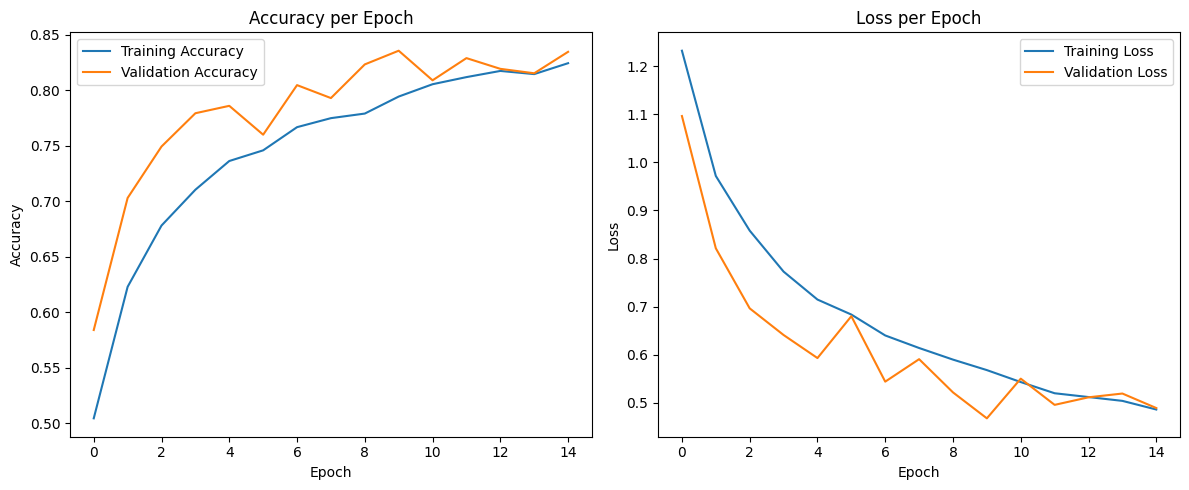

In [ ]:
# Visualisasi loss dan akurasi selama training
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
test_loss, test_acc = model.evaluate(test_generator, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 0.8375 - loss: 0.4547
Test Loss: 0.4672
Test Accuracy: 0.8357


In [ ]:
#Save model menjadi format .h5 biar bisa di test tanpa di training ulang
model.save('jazin.h5')

In [ ]:
#Load model yang sudah di save tadi
from tensorflow.keras.models import load_model
loaded_model = load_model('/content/jazin.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 945ms/step


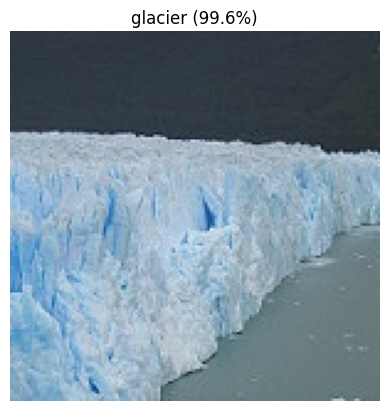

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Ambil label kelas dari generator
class_labels = list(test_generator.class_indices.keys())

def test_image(path):
    # Load & preprocess
    img = Image.open(path).convert('RGB').resize((150,150))
    x   = np.expand_dims(image.img_to_array(img)/150.0, 0)
    # Prediksi
    probs = loaded_model.predict(x)[0]
    idx   = np.argmax(probs)
    label = class_labels[idx]
    conf  = probs[idx]
    # Tampilkan
    plt.imshow(img); plt.axis('off')
    plt.title(f"{label} ({conf*100:.1f}%)")
    plt.show()
    return label, conf

# pemakaian:
test_image('/content/data/seg_pred/seg_pred/10034.jpg')
print(class_labels)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


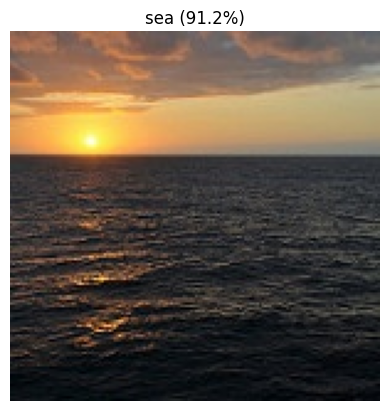

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Ambil label kelas dari generator
class_labels = list(test_generator.class_indices.keys())

def test_image(path):
    # Load & preprocess
    img = Image.open(path).convert('RGB').resize((150,150))
    x   = np.expand_dims(image.img_to_array(img)/150.0, 0)
    # Prediksi
    probs = loaded_model.predict(x)[0]
    idx   = np.argmax(probs)
    label = class_labels[idx]
    conf  = probs[idx]
    # Tampilkan
    plt.imshow(img); plt.axis('off')
    plt.title(f"{label} ({conf*100:.1f}%)")
    plt.show()
    return label, conf

# pemakaian:
test_image('/content/data/seg_pred/seg_pred/10038.jpg')
print(class_labels)